In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4

In [2]:
Training_Images = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_W_Training.npy')
Test_Images = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_W_Test.npy')

Max_Scalar = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_Max_Scalar.npy')
Min_Scalar = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_Min_Scalar.npy')

In [3]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy
import tensorflow as tf
from keras.utils import plot_model

Using TensorFlow backend.
/export/home/gmooers/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/export/home/gmooers/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/export/home/gmooers/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [4]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var))*K.exp(log_var/2)+mean

In [5]:
#latent dim
codings_size = 2

batch_size = 128
img_width = len(Training_Images[0])
img_height = len(Training_Images[0][0])

num =2
d1 = 32
d2 = 3
den1 = 100
den2 = 150
stride = 2

activation = 'selu'
def encoder_gen(num_layers, width, height, dim1, dim2, dense1, dense2, acti, strides, latent_dim):
    inputs = keras.layers.Input(shape=[width, height, 1])
    #inputs = keras.Input(shape=[width, height, 1])
    for i in range(num_layers):
        if i == 0:
            z = keras.layers.convolutional.Conv2D(dim1, dim2, padding='same', activation = acti)(inputs)
        if i == 1:
            z = keras.layers.convolutional.Conv2D(dim1, dim2, padding='same', activation = acti, strides = (stride, stride))(z)
        if i > 1:
            z = keras.layers.convolutional.Conv2D(dim1, dim2, padding='same', activation = acti)(z)
    
    shape_before_flattening = K.int_shape(z)      
    z = keras.layers.Flatten()(inputs)
    z = keras.layers.Dense(dense1, activation=acti)(z)
    #z = keras.layers.Dense(dense2, activation=acti)(z)
    codings_mean = keras.layers.Dense(codings_size)(z)
    codings_log_var = keras.layers.Dense(codings_size)(z)
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = keras.Model(inputs = [inputs], outputs=[codings_mean, codings_log_var, codings])
    return inputs, codings_mean, codings_log_var, codings, variational_encoder, shape_before_flattening

inputs, codings_mean, codings_log_var, codings, variational_encoder, shape_before_flattening = encoder_gen(num, img_width, img_height, d1, d2, den1, den2, activation, stride, codings_size)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
print(shape_before_flattening)

(None, 15, 64, 32)


In [18]:
activation = 'selu'
den1 = 100
den2 = 150
act_function = "sigmoid"
d1 = 32
d2 = 3
strides = 2
small_dim_set = 1
def decoder_gen(latent_dim, dense1, dense2, dim1, dim2, stride, acti, width, height, af, small_dim, shape_before_flat, nums):
    decoder_inputs = keras.layers.Input(shape=[latent_dim])
    x = keras.layers.Dense(np.prod(shape_before_flat[1:]), activation=acti)(decoder_inputs)
    print(x.shape)
    x = keras.layers.Reshape(shape_before_flat[1:])(x)
    print(x.shape)
    #outputs = keras.layers.Reshape([width,height])(x)
    #x = keras.layers.Reshape([width,height, 1])(x)
    x = keras.layers.Conv2DTranspose(dim1, dim2, padding='same', activation=acti, strides=(stride, stride))(x)
    print(x.shape)
    x = keras.layers.Conv2D(small_dim, dim2, padding='same', activation=af)(x)
    print(x.shape)
    outputs = keras.layers.Reshape([width,height,1])(x)
    print(outputs.shape)
    variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])
    return outputs, variational_decoder

outputs, variational_decoder = decoder_gen(codings_size, den1, den2, d1, d2, stride, activation, img_width, img_height, act_function, small_dim_set, shape_before_flattening, num)

(?, 30720)
(?, 15, 64, 32)
(?, ?, ?, 32)
(?, ?, ?, 1)
(?, 30, 128, 1)


In [8]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [9]:
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + codings_log_var - K.square(codings_mean) - K.exp(codings_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    #On ruihan's advice, I will weight KL down
    kl_weight = 0.1
    return K.mean(reconstruction_loss + kl_weight*kl_loss)
    #return K.mean(reconstruction_loss + kl_loss)


def kl(true, pred):
    kl_loss = 1 + codings_log_var - K.square(codings_mean) - K.exp(codings_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return kl_loss

def reconstruction(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    return reconstruction_loss

In [10]:
#latent_loss = -0.5*K.sum(1+codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis = -1)
#variational_ae.add_loss(K.mean(latent_loss)/784.)
variational_ae.compile(loss=kl_reconstruction_loss, optimizer ="rmsprop", metrics=[kl, reconstruction])
variational_ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 128, 1)        0         
_________________________________________________________________
model_1 (Model)              [(None, 2), (None, 2), (N 384504    
_________________________________________________________________
model_2 (Model)              (None, 30, 128, 1)        101697    
Total params: 486,201
Trainable params: 486,201
Non-trainable params: 0
_________________________________________________________________


In [11]:
Training_Images = Training_Images.reshape(Training_Images.shape+(1,))
Test_Images = Test_Images.reshape(Test_Images.shape+(1,))

In [12]:
h = variational_ae.fit(Training_Images, Training_Images, epochs=60, batch_size=batch_size, validation_data=[Test_Images, Test_Images])

Instructions for updating:
Use tf.cast instead.
Train on 8371 samples, validate on 2093 samples
Epoch 1/60
8371/8371 [==============================] - 9s 1ms/step - loss: 2281.4809 - kl: 165.1339 - reconstruction: 2264.9675 - val_loss: 2242.9984 - val_kl: 58.7180 - val_reconstruction: 2237.1266
Epoch 2/60
8371/8371 [==============================] - 1s 166us/step - loss: 2235.9269 - kl: 77.2064 - reconstruction: 2228.2063 - val_loss: 2223.1386 - val_kl: 37.3921 - val_reconstruction: 2219.3994
Epoch 3/60
8371/8371 [==============================] - 1s 173us/step - loss: 2221.8687 - kl: 26.5716 - reconstruction: 2219.2116 - val_loss: 2214.7774 - val_kl: 3.8756 - val_reconstruction: 2214.3899
Epoch 4/60
8371/8371 [==============================] - 1s 175us/step - loss: 2215.8023 - kl: 3.2988 - reconstruction: 2215.4724 - val_loss: 2214.2017 - val_kl: 0.7818 - val_reconstruction: 2214.1235
Epoch 5/60
8371/8371 [==============================] - 1s 174us/step - loss: 2214.7678 - kl: 0.8807

In [13]:
plot_model(variational_encoder, to_file='W_Conv_Model_Structures/vae_W_encoder.png', show_shapes=True)
plot_model(variational_decoder, to_file='W_Conv_Model_Structures/vae_W_decoder.png', show_shapes=True)
plot_model(variational_ae, to_file='W_Conv_Model_Structures/vae_W.png', show_shapes=True)

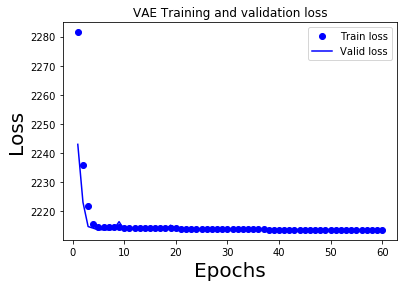

In [14]:
hdict1 = h.history
train_loss_values1 = hdict1['loss']
valid_loss_values1 = hdict1['val_loss']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, train_loss_values1, 'bo', label='Train loss')
plt.plot(epochs1, valid_loss_values1, 'b', label='Valid loss')
plt.title('VAE Training and validation loss')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

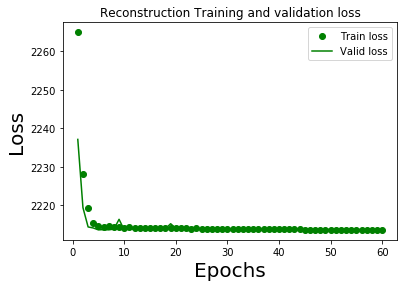

In [15]:
train_loss_values1 = hdict1['reconstruction']
valid_loss_values1 = hdict1['val_reconstruction']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, train_loss_values1, 'go', label='Train loss')
plt.plot(epochs1, valid_loss_values1, 'g', label='Valid loss')
plt.title('Reconstruction Training and validation loss')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

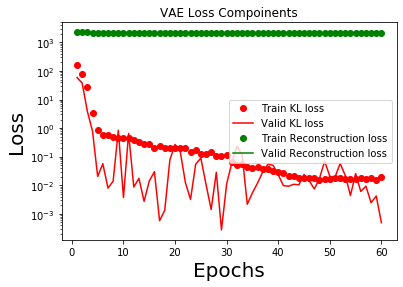

In [16]:
#make a plot for kl and reconstruction loss
kl_train_loss_values1 = hdict1['kl']
kl_valid_loss_values1 = hdict1['val_kl']
recon_train_loss_values1 = hdict1['reconstruction']
recon_valid_loss_values1 = hdict1['val_reconstruction']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, kl_train_loss_values1, 'ro', label='Train KL loss')
plt.plot(epochs1, kl_valid_loss_values1, 'r', label='Valid KL loss')
plt.plot(epochs1, recon_train_loss_values1, 'go', label='Train Reconstruction loss')
plt.plot(epochs1, recon_valid_loss_values1, 'g', label='Valid Reconstruction loss')
plt.title('VAE Loss Compoinents')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

In [17]:
del variational_ae